1. Load Dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset("Helsinki-NLP/opus-100", "en-si")

README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/155k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/65.8M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/153k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/979109 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
print(ds)
print(ds["train"]["translation"][0])

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 979109
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})
{'en': 'Boone!', 'si': 'බුන්!'}


2. Prepare Data for Tokenization

In [ ]:
train_texts_en = [ex["en"] for ex in ds["train"]["translation"]]
train_texts_si = [ex["si"] for ex in ds["train"]["translation"]]

val_texts_en = [ex["en"] for ex in ds["validation"]["translation"]]
val_texts_si = [ex["si"] for ex in ds["validation"]["translation"]]

3. Train Byte-Pair Encoding Tokenizer

In [ ]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

# English tokenizer
tokenizer_en = Tokenizer(models.BPE())
tokenizer_en.pre_tokenizer = pre_tokenizers.Whitespace()
trainer_en = trainers.BpeTrainer(special_tokens=["[PAD]", "[UNK]", "[BOS]", "[EOS]"], vocab_size=16000)
tokenizer_en.train_from_iterator(train_texts_en, trainer=trainer_en)

# Sinhala tokenizer
tokenizer_si = Tokenizer(models.BPE())
tokenizer_si.pre_tokenizer = pre_tokenizers.Whitespace()
trainer_si = trainers.BpeTrainer(special_tokens=["[PAD]", "[UNK]", "[BOS]", "[EOS]"], vocab_size=16000)
tokenizer_si.train_from_iterator(train_texts_si, trainer=trainer_si)

# Save tokenizers
tokenizer_en.save("tokenizer_en.json")
tokenizer_si.save("tokenizer_si.json")

4. Wrap Tokenizers in HF PreTrainedTokenizerFast

In [ ]:
from transformers import PreTrainedTokenizerFast

tok_en = PreTrainedTokenizerFast(tokenizer_file="tokenizer_en.json", bos_token="[BOS]", eos_token="[EOS]",
                                 unk_token="[UNK]", pad_token="[PAD]")
tok_si = PreTrainedTokenizerFast(tokenizer_file="tokenizer_si.json", bos_token="[BOS]", eos_token="[EOS]",
                                 unk_token="[UNK]", pad_token="[PAD]")

In [ ]:
# Inspect how BPE tokenizes a few samples from the dataset
num_samples = 5
samples = ds["validation"].select(range(num_samples))

for i, ex in enumerate(samples["translation"]):
    en_sent = ex["en"]
    si_sent = ex["si"]

    # Tokenize (subword sequence + IDs)
    en_tokens = tok_en.tokenize(en_sent)
    en_ids = tok_en.encode(en_sent)

    si_tokens = tok_si.tokenize(si_sent)
    si_ids = tok_si.encode(si_sent)

    print(f"Sample {i+1}")
    print(f"EN: {en_sent}")
    print(f"EN tokens: {en_tokens}")
    print(f"EN IDs   : {en_ids}")

    print(f"SI: {si_sent}")
    print(f"SI tokens: {si_tokens}")
    print(f"SI IDs   : {si_ids}")
    print("-" * 60)


Sample 1
EN: Sivagami, why use sword for killing a bird, I heard that Baahubali is near that country
EN tokens: ['Siv', 'ag', 'ami', ',', 'why', 'use', 'sword', 'for', 'killing', 'a', 'bird', ',', 'I', 'heard', 'that', 'Baahubali', 'is', 'near', 'that', 'country']
EN IDs   : [9781, 467, 7010, 15, 695, 511, 3521, 414, 2380, 68, 2101, 15, 44, 1187, 395, 11248, 364, 1875, 395, 1810]
SI: - ශිව ගාමි. - කූඹියෙක්ව මරන්න මහ අවි ඇයි ? - බාහුබලි ඒ රාජ්‍යය අහල පහල කියා අහන්න ලැබුනා.
SI tokens: ['-', 'ශිව', 'ගාමි', '.', '-', 'කූ', 'ඹ', 'ියෙක්', 'ව', 'මරන්න', 'මහ', 'අවි', 'ඇයි', '?', '-', 'බාහු', 'බලි', 'ඒ', 'රාජ්\u200dය', 'ය', 'අහල', 'පහල', 'කියා', 'අහන්න', 'ලැබුනා', '.']
SI IDs   : [16, 9895, 11326, 17, 16, 1307, 193, 6935, 197, 1126, 593, 4048, 480, 34, 16, 10121, 8439, 158, 3161, 194, 4078, 2698, 1346, 771, 1975, 17]
------------------------------------------------------------
Sample 2
EN: I do believe we've known each other since forever, though.
EN tokens: ['I', 'do', 'believe', 'we', "'", 'v

In [ ]:
for i in range(3):
    en_sent = ds["validation"][i]["translation"]["en"]
    ref_si = ds["validation"][i]["translation"]["si"]

    # encode returns a 1xN tensor
    encoded = tok_si(ref_si, return_tensors="pt")  # note: using __call__ is better
    input_ids = encoded['input_ids'][0]            # take first (and only) batch

    # convert tensor to list
    decoded = tok_si.decode(input_ids.tolist(), skip_special_tokens=True)

    print(f"encoded: {ref_si}")
    print(f"decoded: {decoded}")
    print("-" * 40)


encoded: - ශිව ගාමි. - කූඹියෙක්ව මරන්න මහ අවි ඇයි ? - බාහුබලි ඒ රාජ්‍යය අහල පහල කියා අහන්න ලැබුනා.
decoded: - ශිව ගාමි . - කූ ඹ ියෙක් ව මරන්න මහ අවි ඇයි ? - බාහු බලි ඒ රාජ්‍ය ය අහල පහල කියා අහන්න ලැබුනා .
----------------------------------------
encoded: මං විශ්වාස කරන්නෙ අපි එකිනෙකා හඳුනාගත්ත දා ඉඳං සදහටම එක්ට ඉන්න එක විතරයි.
decoded: මං විශ්වාස කරන්නෙ අපි එකිනෙකා හඳුනා ගත්ත දා ඉඳං සදහටම එක් ට ඉන්න එක විතරයි .
----------------------------------------
encoded: "පළමු දේ තමයි නිවැරදි වෙන්නෙ."
decoded: " පළමු දේ තමයි නිවැරදි වෙන්නෙ ."
----------------------------------------


5. Encode Dataset

In [ ]:
import torch

max_len = 64

def encode_batch(batch):
    en_texts = [item["en"] for item in batch]
    si_texts = [item["si"] for item in batch]

    en = tok_en(en_texts, padding="max_length", truncation=True, max_length=max_len)
    si = tok_si(si_texts, padding="max_length", truncation=True, max_length=max_len)
    return {
        "input_ids": en["input_ids"],
        "attention_mask": en["attention_mask"],
        "labels": si["input_ids"]
    }

train_ds = ds["train"].map(lambda x: encode_batch(x["translation"]), batched=True, remove_columns=["translation"])
val_ds = ds["validation"].map(lambda x: encode_batch(x["translation"]), batched=True, remove_columns=["translation"])

train_ds.set_format(type="torch")
val_ds.set_format(type="torch")

Map:   0%|          | 0/979109 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

6. Define Transformer Model

In [ ]:
from transformers import EncoderDecoderModel, BertConfig, BertModel, EncoderDecoderConfig

# Encoder config (English)
encoder_config = BertConfig(
    vocab_size=len(tok_en),
    hidden_size=256,
    num_hidden_layers=4,
    num_attention_heads=4,
    intermediate_size=512,
    max_position_embeddings=128,
    pad_token_id=tok_en.pad_token_id,
    bos_token_id=tok_en.bos_token_id,
    eos_token_id=tok_en.eos_token_id,
)

# Decoder config (Sinhala) – note: add_is_decoder & cross-attention
decoder_config = BertConfig(
    vocab_size=len(tok_si),
    hidden_size=256,
    num_hidden_layers=4,
    num_attention_heads=4,
    intermediate_size=512,
    max_position_embeddings=128,
    pad_token_id=tok_si.pad_token_id,
    bos_token_id=tok_si.bos_token_id,
    eos_token_id=tok_si.eos_token_id,
    is_decoder=True,
    add_cross_attention=True,
)

#model = EncoderDecoderModel.from_encoder_decoder_config(
#    encoder_config=encoder_config,
#    decoder_config=decoder_config
#)

# Build encoder-decoder model
#encoder_model = BertModel(config=encoder_config)
#decoder_model = BertModel(config=decoder_config)

#model = EncoderDecoderModel(encoder=encoder_model, decoder=decoder_model)
#model = EncoderDecoderModel(encoder=encoder_config, decoder=decoder_config)
config = EncoderDecoderConfig.from_encoder_decoder_configs(encoder_config, decoder_config)
model = EncoderDecoderModel(config=config)

# Tie embeddings to reduce params (optional but helps)
model.config.decoder_start_token_id = tok_si.bos_token_id
model.config.pad_token_id = tok_si.pad_token_id


In [ ]:
# Print model config (layers, heads, hidden sizes, etc.)
print(model)

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(16000, 256, padding_idx=0)
      (position_embeddings): Embedding(128, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, elem

7. Training Setup

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

batch_size = 16

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    logging_steps=500,
    save_steps=1000,
    eval_steps=1000,
    num_train_epochs=1,  # for demo, increase for real
    fp16=torch.cuda.is_available(),
    report_to=[],
)

data_collator = DataCollatorForSeq2Seq(tokenizer=tok_en, model=model)

8. BLEU Evaluation Function

In [ ]:
import sacrebleu

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tok_si.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tok_si.batch_decode(labels, skip_special_tokens=True)

    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels], force=True)
    return {"bleu": bleu.score}

9. Trainer

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tok_en,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1029687089.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


10. Train and Evaluate

In [ ]:
trainer.train()
metrics = trainer.evaluate()
print(metrics)

/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduce

Step,Training Loss,Validation Loss,Bleu
1000,0.888400,0.987970,0.070294
2000,0.808300,0.949032,0.693387
3000,0.777300,0.926357,1.367991
4000,0.777700,0.908211,1.430252
5000,0.758400,0.893691,1.604072
6000,0.743200,0.880014,1.807936
7000,0.735900,0.868146,1.832108
8000,0.737500,0.857370,1.799975
9000,0.714700,0.847265,2.369959
10000,0.709900,0.839438,2.472501


/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no 

Step,Training Loss,Validation Loss,Bleu
1000,0.888400,0.987970,0.070294
2000,0.808300,0.949032,0.693387
3000,0.777300,0.926357,1.367991
4000,0.777700,0.908211,1.430252
5000,0.758400,0.893691,1.604072
6000,0.743200,0.880014,1.807936
7000,0.735900,0.868146,1.832108
8000,0.737500,0.857370,1.799975
9000,0.714700,0.847265,2.369959
10000,0.709900,0.839438,2.472501


/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:577: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no 

{'eval_loss': 0.7032955884933472, 'eval_bleu': 4.684270603952535, 'eval_runtime': 20.7434, 'eval_samples_per_second': 96.416, 'eval_steps_per_second': 6.026, 'epoch': 1.0}


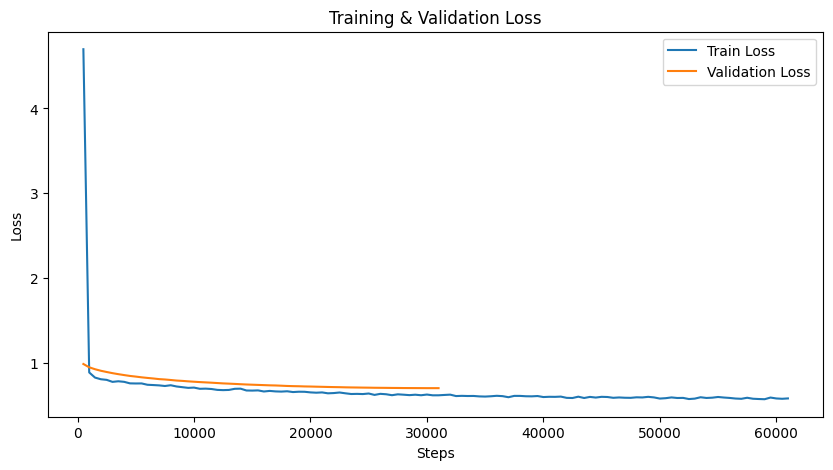

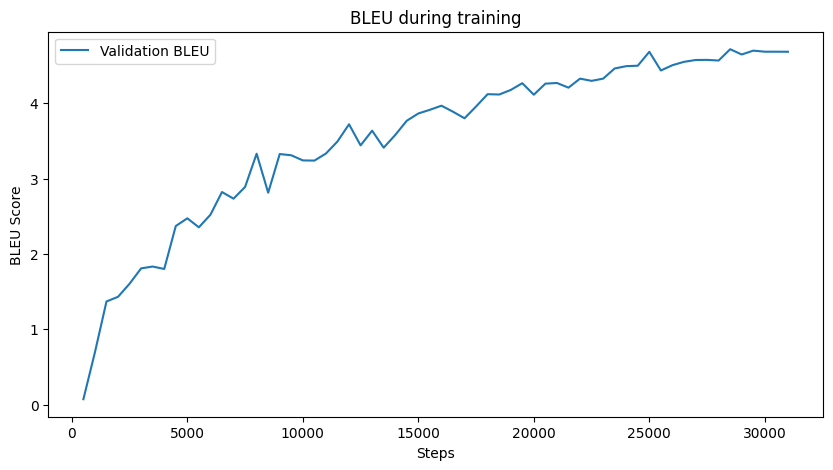

In [ ]:
import matplotlib.pyplot as plt

# After training
history = trainer.state.log_history

steps = []
train_loss = []
eval_loss = []
bleu = []

for record in history:
    if "loss" in record.keys() and "step" in record.keys():
        steps.append(record["step"])
        train_loss.append(record["loss"])
    if "eval_loss" in record.keys():
        eval_loss.append(record["eval_loss"])
    if "eval_bleu" in record.keys():
        bleu.append(record["eval_bleu"])

plt.figure(figsize=(10,5))
plt.plot(steps[:len(train_loss)], train_loss, label="Train Loss")
if eval_loss:
    plt.plot(steps[:len(eval_loss)], eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

if bleu:
    plt.figure(figsize=(10,5))
    plt.plot(steps[:len(bleu)], bleu, label="Validation BLEU")
    plt.xlabel("Steps")
    plt.ylabel("BLEU Score")
    plt.legend()
    plt.title("BLEU during training")
    plt.show()


In [ ]:
# Save model + trainer state
save_path = "./bpe_translation_model"
trainer.save_model(save_path)

In [ ]:
import shutil
from google.colab import files

# Replace 'my_folder' with your folder name
shutil.make_archive('bpe_translation_model', 'zip', 'bpe_translation_model')

# Download the zip
files.download('bpe_translation_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
shutil.unpack_archive("bpe_translation_model.zip", "bpe_translation_model_loaded")
zip_path = "./bpe_translation_model_loaded"
loaded_model = EncoderDecoderModel.from_pretrained(zip_path)

In [ ]:
# Pick a few sentences from validation
for i in range(5):
    en_sent = ds["validation"][i]["translation"]["en"]
    ref_si = ds["validation"][i]["translation"]["si"]

    # Encode English input
    input_ids = torch.tensor([tok_en.encode(en_sent, max_length=64)]).to(loaded_model.device)

    # Generate translation
    output_ids = loaded_model.generate(input_ids, max_length=64)
    pred_si = tok_si.decode(output_ids[0].tolist(), skip_special_tokens=True)

    print(f"EN: {en_sent}")
    print(f"REF: {ref_si}")
    print(f"PRED: {pred_si}")
    print("-" * 50)


EN: Sivagami, why use sword for killing a bird, I heard that Baahubali is near that country
REF: - ශිව ගාමි. - කූඹියෙක්ව මරන්න මහ අවි ඇයි ? - බාහුබලි ඒ රාජ්‍යය අහල පහල කියා අහන්න ලැබුනා.
PRED: - මම , ඇයි ඔයා මේ මගුල ව මරන්න හදන්නේ , මම මේ කාර් එකේ තියෙන එකම දේ ගැන .
--------------------------------------------------
EN: I do believe we've known each other since forever, though.
REF: මං විශ්වාස කරන්නෙ අපි එකිනෙකා හඳුනාගත්ත දා ඉඳං සදහටම එක්ට ඉන්න එක විතරයි.
PRED: මම විශ්වාස කරනවා අපි හැමෝම දන්නවා කියලා , ඒ වගේම , ඒත් ...
--------------------------------------------------
EN: "First instinct, usually the right one."
REF: "පළමු දේ තමයි නිවැරදි වෙන්නෙ."
PRED: " මුලින්ම ඒ වගේම , ඒ වගේම , ඒ වගේම .
--------------------------------------------------
EN: I just ran a second check on the ramps. They look good.
REF: මම දැන් දෙවනි පාරටත් අට අර කළබලේ මැද්දට ගියා.එයාලා හොදට පේනවා.
PRED: මම මේ වගේ වැඩ කරන එක ටිකක් බලන්න .
--------------------------------------------------
EN: By a part of my governmen